# Lab session 2: Multiple Outputs and Sparse GPs 

Gaussian Process Summer School, 12th September 2017
written by Ricardo Andrade Pacheco, Neil Lawrence and James Hensman

In this lab we are going to build on yestereday's work by looking at multiple output Gaussian processes and considering low rank approximations to Gaussian processes.

## 1 Getting started: Modelling Multiple Outputs

Just as in the first lab, we firstly specify to include plots in the notebook and to import relevant libraries.

In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

Populating the interactive namespace from numpy and matplotlib


We ned pods to run this notebook. You can install it using pip

``pip install pods``

### Running Example

The first think we will look at is a multiple output model. Our aim is to jointly model all *sprinting* events from olympics since 1896. Data is provided by Rogers & Girolami's "First Course in Machine Learning". Firstly, let's load in the data.

In [2]:
import pods
pods.datasets.authorize_download = lambda x: True
data = pods.datasets.olympic_sprints()

In [3]:
X = data['X']
y = data['Y']
print(data['info'], data['details'])

Olympics sprint event winning for men and women to 2008. Data is from Rogers and Girolami's First Course in Machine Learning. Data from the textbook 'A First Course in Machine Learning'. Available from http://www.dcs.gla.ac.uk/~srogers/firstcourseml/.


When using data sets it's good practice to cite the originators of the data, you can get information about the source of the data from `data['citation']`

In [4]:
print (data['citation'])

A First Course in Machine Learning. Simon Rogers and Mark Girolami: Chapman & Hall/CRC, ISBN-13: 978-1439824146


The data consists of all the male and female sprinting data for 100m, 200m and 400m since 1896 (six outputs in total). The ouput information can be found from: `data['output_info']`

In [5]:
print (data['output_info'])

{0: '100m Men', 1: '100m Women', 2: '200m Men', 3: '200m Women', 4: '400m Men', 5: '400m Women'}


In GPy we deal with multiple output data in a particular way. We specify the output we are interested in for modelling as an additional *input*. So whilst for this data, normally, the only input would be the year of the event. We additionally have an input giving the index of the output we are modelling. This can be seen from examining `data['X']`.

In [6]:
print ('First column of X contains the olympic years.')
print (data['X'][:, 0])
print ('Second column of X contains the event index.')
print (data['X'][:, 1])

First column of X contains the olympic years.
[ 1896.  1900.  1904.  1906.  1908.  1912.  1920.  1924.  1928.  1932.
  1936.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.  1928.  1932.  1936.
  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.  1984.
  1988.  1992.  1996.  2000.  2004.  2008.  1900.  1904.  1908.  1912.
  1920.  1924.  1928.  1932.  1936.  1948.  1952.  1956.  1960.  1964.
  1968.  1972.  1976.  1980.  1984.  1988.  1992.  1996.  2000.  2004.
  2008.  1948.  1952.  1956.  1960.  1964.  1968.  1972.  1976.  1980.
  1984.  1988.  1992.  1996.  2000.  2004.  2008.  1896.  1900.  1904.
  1906.  1908.  1912.  1920.  1924.  1928.  1932.  1936.  1948.  1952.
  1956.  1960.  1964.  1968.  1972.  1976.  1980.  1984.  1988.  1992.
  1996.  2000.  2004.  2008.  1964.  1968.  1972.  1976.  1980.  1984.
  1988.  1992.  1996.  2000.  2004.  2008.]
Second column of X contains the event index.
[ 0.  0.  0. 

Now let's plot the data

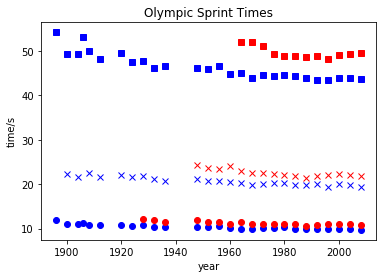

In [7]:
markers = ['bo', 'ro', 'bx', 'rx', 'bs', 'rs']
for i in range(6):
    # extract the event 
    x_event = X[np.nonzero(X[:, 1]==i), 0]
    y_event = y[np.nonzero(X[:, 1]==i), 0]
    pb.plot(x_event, y_event, markers[i])
pb.title('Olympic Sprint Times')
xlabel('year')
ylabel('time/s')

In the plot above red is women's events, blue is men's. Squares are 400 m, crosses 200m and circles 100m. Not all events were run in all years, for example the women's 400 m only started in 1964.

We will look at modelling the data using coregionalization approaches described in this morning's lecture. We introduced these approaches through the Kronecker product. To indicate we want to construct a covariance function of this type in GPy we've overloaded the `**` operator. Stricly speaking this operator means to the power of (like `^` in MATLAB). But for covariance functions we've used it to indicate a tensor product. The linear models of coregionalization we introduced in the lecture were all based on combining a matrix with a standard covariance function. We can think of the matrix as a particular type of covariance function, whose elements are referenced using the event indices. I.e. $k(0, 0)$ references the first row and column of the coregionalization matrix. $k(1, 0)$ references the second row and first column of the coregionalization matrix. Under this set up, we want to build a covariance where the first column from the features (the years) is passed to a covariance function, and the second column from the features (the event number) is passed to the coregionalisation matrix. Let's start by trying a intrinsic coregionalisation model (sometimes known as multitask Gaussian processes). Let's start by checking the help for the `coregionalize` covariance.

In [8]:
GPy.kern.Coregionalize?

The coregionalize matrix, $\mathbf{B}$, is itself is constructed from two other matrices, $\mathbf{B} = \mathbf{W}\mathbf{W}^\top + \text{diag}(\boldsymbol{\kappa})$. This allows us to specify a low rank form for the coregionalization matrix. However, for our first example we want to specify that the matrix $\mathbf{B}$ is not constrained to have a low rank form. 

In [9]:
kern = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1,output_dim=6, rank=5)

Note here that the rank we specify is that of the $\mathbf{W}\mathbf{W}^\top$ part. When this part is combined with the diagonal matrix from $\mathbf{\kappa}$ the matrix $\mathbf{B}$ is totally general. This covariance function can now be used in a standard Gaussian process regression model. Let's build the model and optimize it.

In [10]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

We can plot the results using the ability to 'fix inputs' in the `model.plot()` function. We can specify that column 1 should be fixed to event number 2 by passing `fixed_inputs = [(1, 2)]` to the model. To plot the results for all events on the same figure we also specify `fignum=1` in the loop as below. 

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


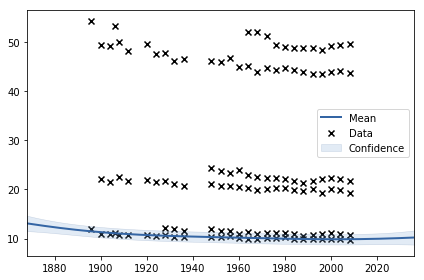

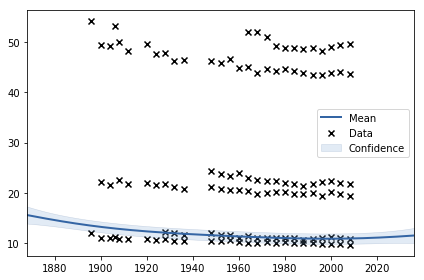

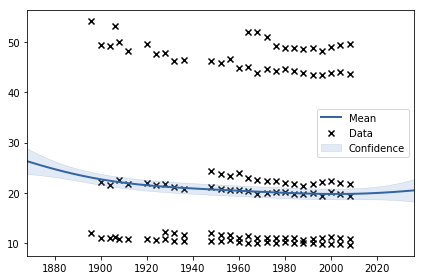

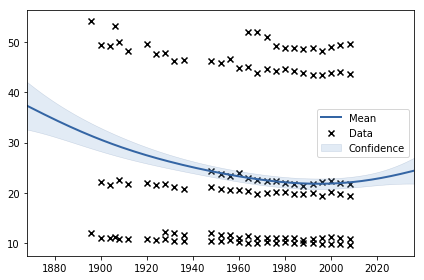

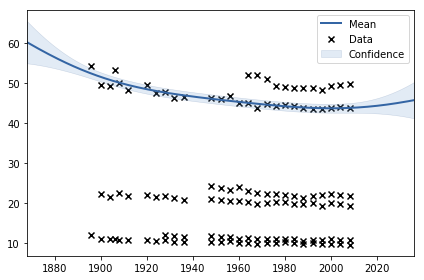

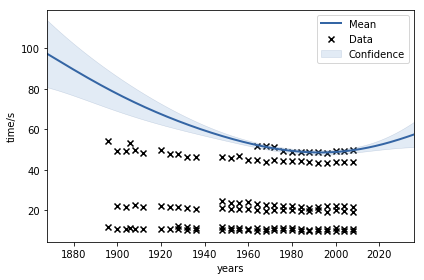

In [11]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

There is a lot we can do with this model. First of all, each of the races is a different length, so the series have a different mean. We can include another coregionalization term to deal with the mean. Below we do this and reduce the rank of the coregionalization matrix to 1.

In [12]:
kern1 = GPy.kern.RBF(1, lengthscale=80)**GPy.kern.Coregionalize(1, output_dim=6, rank=1)
kern2 = GPy.kern.Bias(1)**GPy.kern.Coregionalize(1,output_dim=6, rank=1)
kern = kern1 + kern2

In [13]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


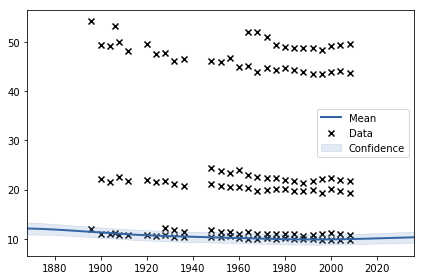

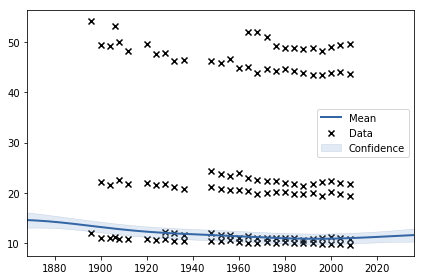

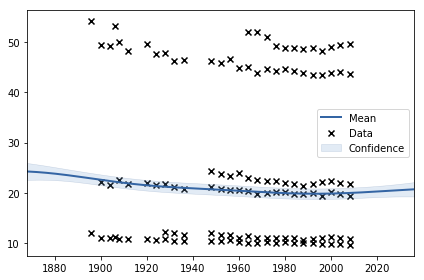

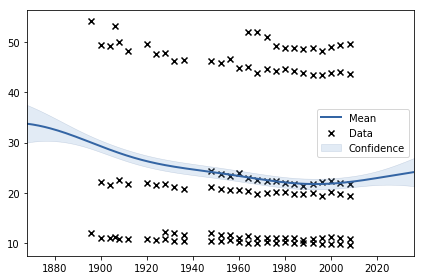

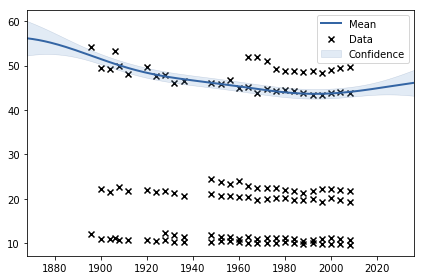

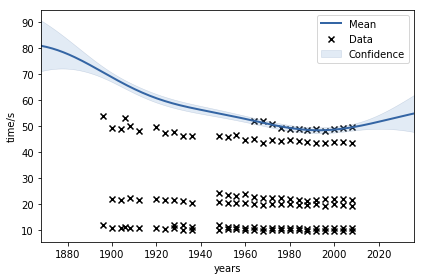

In [14]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

This is a simple form of the linear model of coregionalization. Note how confident the model is about what the women's 400 m performance would have been. You might feel that the model is being over confident in this region. Perhaps we are forcing too much sharing of information between the sprints. We could return to the intrinsic coregionalization model and force the two base covariance functions to share the same coregionalization matrix.

In [15]:
kern1 = GPy.kern.RBF(1, lengthscale=80) + GPy.kern.Bias(1)
kern2 = GPy.kern.Coregionalize(1, output_dim=6, rank=5)
kern = kern1**kern2

In [16]:
model = GPy.models.GPRegression(X, y, kern)
model.optimize()

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


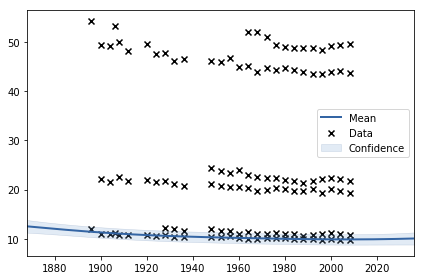

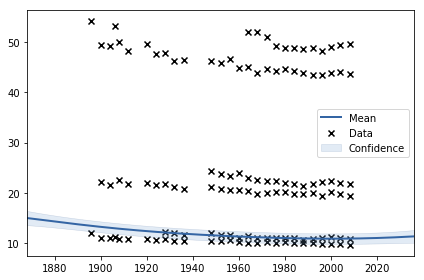

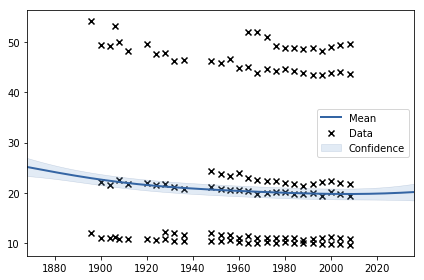

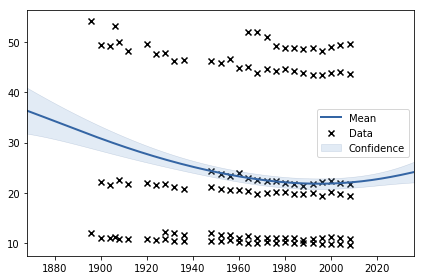

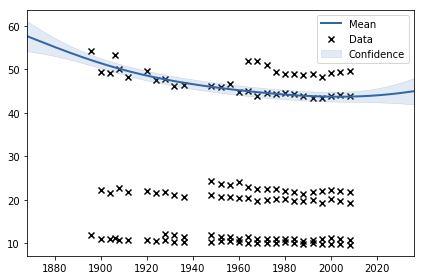

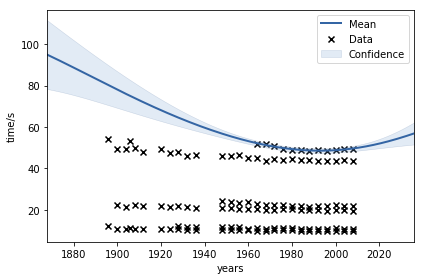

In [17]:
for i in range(6):
    model.plot(fignum=1,fixed_inputs=[(1, i)])
xlabel('years')
ylabel('time/s')

### Exercise 1

Can you fix the issue with over confidence in this model? Some things you might try include (a) adding additional covariance functions to handle shorter lengthscale effects. (b) Changing the rank of the coregionalization matrix. (c) Adding a coregionalized noise model using `GPy.kern.White(1)`.

(Reminder; the women's 400m is output number 5.)

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


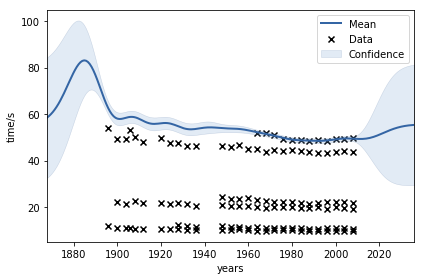

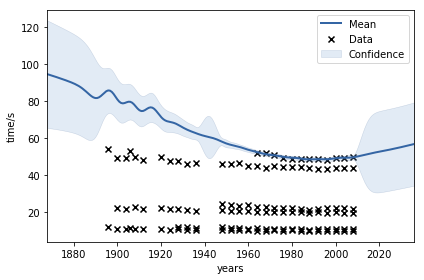

In [72]:
# Question 1 answer here
#(a) add additional cov fns to handle shorter lengthscales:

kern1 = GPy.kern.RBF(1, lengthscale=10) + GPy.kern.Bias(1)
kern2 = GPy.kern.Coregionalize(1, output_dim=6, rank=5)
kern = kern1**kern2

model = GPy.models.GPRegression(X, y, kern)
model.kern.sum.rbf.lengthscale.fix(10.0)
model.optimize()

model.plot(fignum=1,fixed_inputs=[(1, 5)])
xlabel('years')
ylabel('time/s')

#this isn't very helpful as, although the uncertainty increases outside the domain of the other data
#the other data still supports the mean over its domain.

#we could add another kernel outside the coregionalisation??? I found to make this work I needed
#a lot of fixed things.

kern1 = GPy.kern.RBF(1, lengthscale=80, name='coregrbf') + GPy.kern.Bias(1)
kern2 = GPy.kern.Coregionalize(1, output_dim=6, rank=5)
kern = kern1**kern2 + GPy.kern.RBF(1,lengthscale=10,name='extranoise')

model = GPy.models.GPRegression(X, y, kern)
model.kern.extranoise.lengthscale.fix(5.0)
model.kern.extranoise.variance.fix(125.0)
model.kern.mul.sum.coregrbf.lengthscale.fix(80.0)
model.kern.mul.sum.coregrbf.variance.fix(1.0)
model.optimize()

model.plot(fignum=1,fixed_inputs=[(1, 5)])
xlabel('years')
ylabel('time/s')

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


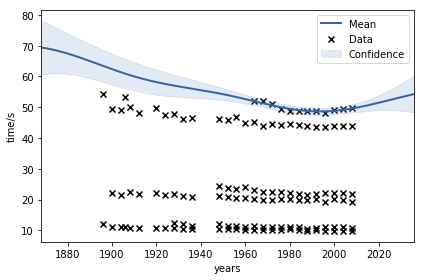

In [76]:
#(b) Changing the rank of the coregionalization matrix.

kern1 = GPy.kern.RBF(1, lengthscale=80) + GPy.kern.Bias(1)
kern2 = GPy.kern.Coregionalize(1, output_dim=6, rank=1)
kern = kern1**kern2

model = GPy.models.GPRegression(X, y, kern)
model.optimize()

model.plot(fignum=1,fixed_inputs=[(1, 5)])
xlabel('years')
ylabel('time/s')

#making it smaller means less of the variation in an output can be explained in the same way across outputs,
#but means there's few options - which effectively means the uncertainty is artificially reduced.??

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


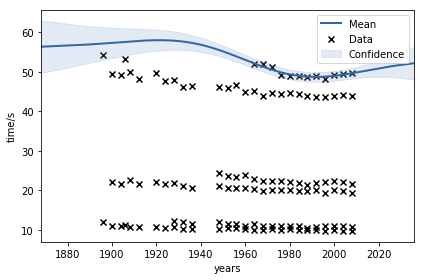

In [80]:
#(c) Adding a coregionalized noise model using GPy.kern.White(1).

#here I've actually combined all of the above suggestions.

kern1 = GPy.kern.RBF(1, lengthscale=20) + GPy.kern.Bias(1) + GPy.kern.White(1)
kern2 = GPy.kern.Coregionalize(1, output_dim=6, rank=3)
kern = kern1**kern2

model = GPy.models.GPRegression(X, y, kern)
model.optimize()

model.plot(fignum=1,fixed_inputs=[(1, 5)])
xlabel('years')
ylabel('time/s')

Predictions in the multioutput case can be very effected by our covariance function *design*. This reflects the themes we saw on the first day where the importance of covariance function choice was emphasized at design time. 

## 2 Low Rank Approximations

In the worst case, inference in a Gaussian process is $\mathcal{O}(n^3)$ computational complexity and $\mathcal{O}(n^2)$ storage. For efficient inference in larger data sets we need to consider approximations. One approach is low rank approximation of the covariance matrix (also known as sparse approximations or perhaps more accurately parsimonious approximations). We'll study these approximations by first creating a simple data set by sampling from a GP.

In [81]:
X = np.sort(np.random.rand(50,1)*12,0)
k = GPy.kern.RBF(1)
K = k.K(X)
K+= np.eye(50)*0.01 # add some independence (noise) to K
y = np.random.multivariate_normal(np.zeros(50), K).reshape(50,1)

Build a straightforward GP model of our simulation. We’ll also plot the posterior of $f$.

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


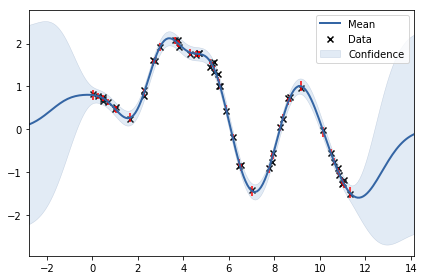

In [82]:
m = GPy.models.GPRegression(X,y)
m.optimize()
m.plot()
mu, var = m._raw_predict(X) # this fetches the posterior of f
pb.vlines(X[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

### Exercise 2

One thought that occurs is as follows. Do we need all the data to create this posterior estimate? Are any of the data points redundant? What happens to the model if you remove some data?

*Hint:* 

To delete the first few items use:

`X2 = np.delete(X,range(8),0)`

`y2 = np.delete(y,range(8),0)`

To keep just every fifth item:

`X2 = X[0::5,:]`

`y2 = y[0::5,:]`

You could plot all the data too, or compare with the above plot.

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


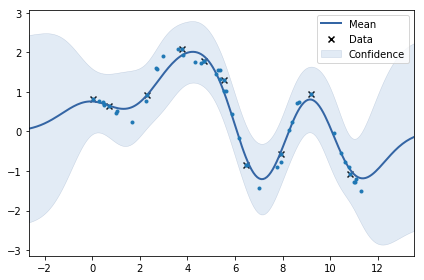

In [89]:
# Exercise 2 answer here

X2 = X[0::5,:]
y2 = y[0::5,:]
m = GPy.models.GPRegression(X2,y2)
m.optimize()
m.plot()
plt.plot(X,y,'.')

Hopefully you'll notice that, at least in this simple example, much of the data is relatively redundant!

### Building the Low Rank Approximation

Now we’ll consider a GP that uses a low rank approximation to fit the data.

In [96]:
Z = np.random.rand(3,1)*12 #these are the locations of the three 'inducing', 'sparse' or 'pseudo' inputs.
m = GPy.models.SparseGPRegression(X,y,Z=Z)
print (m)


Name : sparse_gp
Objective : 73.92118776369908
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (3, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


$\mathbf{Z}$ are the locations of the 'inducing', 'sparse' or 'pseudo' inputs. Plot the posterior in the same manner as for the full GP: (note here we're not plotting the likelihood noise, as we're interested in the latent function, that we're approximating with the inducing points).

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


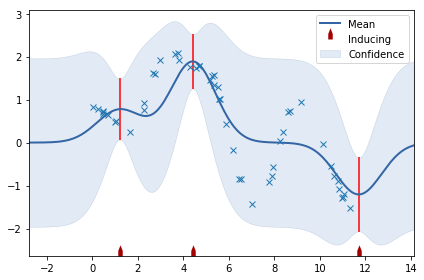

In [106]:
m.plot_noiseless()
plt.plot(X,y,'x')
mu, var = m.predict_noiseless(Z) 
pb.vlines(Z[:,0], mu[:,0]-2.*np.sqrt(var[:,0]), mu[:,0]+2.*np.sqrt(var[:,0]),color='r')

You'll see that three inducing points probably is insufficient to properly describe the complexity of the originating function.

### Exercise 3

a) Optimise and plot the model.

b) The inducing inputs are marked – how are they placed? (hint you can view the values of the inducing points with `m.Z`)

c) You can move them around with e.g. `m.Z[1,0] = 5`, where the first index is the id of the point and the second is the dimension of the input space (in this case it's 1d).

d) What happens to the likelihood? 

e) What happens to the fit if you remove an input?

Hint: You can plot the data on the same plot by calling `plt.plot(X,y,'x')` after `m.plot_noiseless()`

In [113]:
# Exercise 3 answers

f) How does the fit of the sparse compare with the full GP? Play around
with the number of inducing inputs, the fit should improve as $M$ increases. How many
inducing points are needed? What do you think happens in higher dimensions?

In [114]:
# Exercise 3 f answer

# Extra?

If you've got this far, start on the GPLVM notebook!